# Convolutional Neural Network
### (in Numpy)

In [2]:
import numpy as np
from scipy.signal import convolve2d, correlate2d
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

## Getting the Data

Data shape in general = $x:[n\times c_{in} \times h \times w]$

In our case: $n = 16, c_{in} = 1, w = 3, h = 3$

For the math derivations, we won't need the batch size

In [3]:
BATCH_SIZE = 16
C_IN = 1
W = 3
H = 3
C_OUT = 3

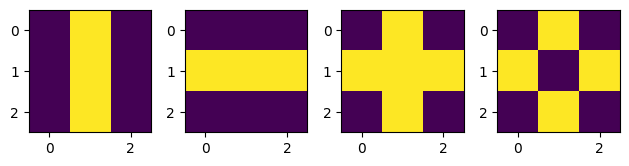

In [5]:
V_LINE = np.array([[0, 1, 0], [0, 1, 0], [0, 1, 0]]).reshape(C_IN, H, W)
H_LINE = np.array([[0, 0, 0], [1, 1, 1], [0, 0, 0]]).reshape(C_IN, H, W)
CROSS = np.clip(V_LINE + H_LINE, a_min=0, a_max=1).reshape(C_IN, H, W)
DIAMOND = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]).reshape(C_IN, H, W)

_, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4) # 1 row, 4 columns


ax1.imshow(np.array([[0, 1, 0], [0, 1, 0], [0, 1, 0]]))
ax2.imshow(np.array([[0, 0, 0], [1, 1, 1], [0, 0, 0]]))
ax3.imshow(np.clip(np.array([[0, 1, 0], [0, 1, 0], [0, 1, 0]]) + np.array([[0, 0, 0], [1, 1, 1], [0, 0, 0]]), a_min=0, a_max=1))
ax4.imshow(np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]))

plt.tight_layout()


SHAPES = {
    "v_line":V_LINE,
    "h_line": H_LINE,
    "cross": CROSS,
    "diamond": DIAMOND
}
TARGETS = {
    "v_line":0,
    "h_line": 1,
    "cross": 2,
    "diamond": 3
}

In [4]:
def generate_single_data_point(shape: str):
    return TARGETS[shape], (SHAPES[shape] + np.random.uniform(-0.25, 0.25, size=(C_IN, H, W)))

def generate_dataset(n=500, batch_size=16):
    def split_into_batches(x, batch_size):
        n_batches = len(x) / batch_size
        x = np.array_split(x, n_batches)
        return np.array(x, dtype=object)
    one_hot_encoder = OneHotEncoder()

    shapes = list(SHAPES.keys())
    dataset = [generate_single_data_point(np.random.choice(shapes)) for _ in range(n)]
    labels = []
    data = []
    for y, x in dataset:
        labels.append(y)
        data.append(x)
    
    targets = np.array(labels)
    data = np.array(data)
    X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.33, random_state=RANDOM_SEED)

    X_train = split_into_batches(
        X_train, batch_size
    )

    X_test = split_into_batches(
        X_test, batch_size
    )
    
    # Turn the targets into Numpy arrays and flatten the array
    y_train = np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)

    # One-Hot encode the training data and split it into batches (same as with the training data)
    one_hot_encoder.fit(y_train)
    y_train = one_hot_encoder.transform(y_train).toarray()
    y_train = split_into_batches(np.array(y_train), batch_size)

    one_hot_encoder.fit(y_test)
    y_test = one_hot_encoder.transform(y_test).toarray()
    y_test = split_into_batches(np.array(y_test), batch_size)

    return X_train, y_train, X_test, y_test



## Forward Propagation

$Y^j_n = B^j + \sum_{i=0}^{C_{in}}X^i_n \star_{valid} K^j_i \quad\quad \forall n:[0, \dots, N]$

### Initiating random kernels and biases

In [5]:
KERNEL_SIZE = 2

In [6]:
def conv2d_forward(x: np.array, kernels: np.array, bias: np.array):
    c_out, c_in, k, _ = kernels.shape
    N, c_in, h_in, w_in = x.shape
    h_out = h_in - k + 1
    w_out = w_in - k + 1
    output_shape = N, c_out, h_out, w_out
    output = np.zeros(shape=output_shape)
    for n in range(N):
        for j in range(c_out):
            output[n, j] = bias[j]
            for i in range(c_in):
                output[n, j] += correlate2d(
                    x[n, i], kernels[j, i], mode="valid"
                )
    return output

In [7]:
def conv2d_kernel_gradient(dE_dY: np.array, x: np.array):
    n, c_out, h_out, w_out = dE_dY.shape
    _, c_in, h_in, w_in = x.shape
    k = h_in + 1 - h_out
    dK = np.zeros(shape=(c_out, c_in, k, k))
    for batch in range(n):
        for i in range(c_out):
            for j in range(c_in):
                dK[i, j] += correlate2d(dE_dY[batch, i], x[batch, j], mode="valid")

    return dK / n

In [9]:
def conv2d_bias_gradient(dE_dY: np.ndarray):
    n, c_out, _, _ = dE_dY.shape
    dB = dE_dY.sum(axis=(0, 2, 3)) / n
    return dB

In [10]:
def conv2d_input_gradient(dE_dY: np.ndarray, kernels: np.ndarray):
    n, c_out, h_out, w_out = dE_dY.shape
    c_out, c_in, k, _ = kernels.shape
    h_in = h_out + k - 1
    w_in = w_out + k - 1
    dX = np.zeros((n, c_in, h_in, w_in))

    for batch in range(n):
        for j in range(c_in):
            for i in range(c_out):
                dX[batch, j] += convolve2d(dE_dY[batch, i], kernels[i, j], mode="full")
    return dX


In [11]:
def init_random_kernels(c_in, c_out, kernel_size):
    return np.random.randn(c_out, c_in, kernel_size, kernel_size)


def init_random_bias(c_out):
    return np.random.randn(c_out)

In [12]:
class Conv2D:
    def __init__(self, c_in, c_out, kernel_size) -> None:
        self.k = init_random_kernels(c_in, c_out, kernel_size)
        self.b = init_random_bias(c_out)
    
    def forward(self, x: np.ndarray):
        self.x = x
        return conv2d_forward(x, self.k, self.b)

    def backward(self, dE_dY: np.ndarray):
        dK = conv2d_kernel_gradient(dE_dY, self.x)
        dB = conv2d_bias_gradient(dE_dY)
        dX = conv2d_input_gradient(dE_dY, self.k)

        return {"dK": dK, "dB": dB, "dX": dX}

    def update(self, grads, learning_rate):
        self.k -= grads["dK"] * learning_rate
        self.b -= grads["dB"] * learning_rate

In [13]:
class Flatten:
    def __init__(self):
        self.x = None

    def forward(self, x: np.ndarray):
        self.x = x
        n = x.shape[0]
        return self.x.reshape((n, -1))

    def backward(self, dE_dY: np.ndarray):
        return {"dX": dE_dY.reshape(self.x.shape)}

    def update(self, grads, learning_rate):
        pass

In [14]:
def init_dense_layer(n_in, n_out) -> tuple[np.ndarray, np.ndarray]:
    w = np.random.randn(n_in, n_out) * 0.1
    b = (
        np.random.randn(
            n_out,
        )
        * 0.1
    )

    return w, b


def forward_single_dense_layer(x: np.ndarray, w: np.ndarray, b: np.ndarray):
    return x @ w + b


def get_weight_gradient_single_dense_layer(x: np.ndarray, dE_dY: np.ndarray):
    return x.T @ dE_dY


def get_bias_gradient_single_dense_layer(dE_dY: np.ndarray):
    return np.sum(dE_dY, axis=0) / dE_dY.shape[0]


def get_input_gradient_single_dense_layer(dE_dY: np.ndarray, w: np.ndarray):
    return dE_dY @ w.T

In [15]:
class ReLU:
    def __init__(self) -> None:
        self.x = None

    @staticmethod
    def relu(Z):
        return np.maximum(0, Z)

    @staticmethod
    def relu_backward(x):
        x[x <= 0] = 0
        x[x > 0] = 1
        return x

    def forward(self, x):
        self.x = x
        return self.relu(x)

    def backward(self, dE_dY):
        dX = np.multiply(dE_dY, self.relu_backward(self.x))
        return {"dX": dX}

    def update(self, *args, **kwargs):
        pass


class Sigmoid:
    def __init__(self):
        self.x = None
        pass

    @staticmethod
    def sigmoid(Z):
        return 1 / (1 + np.exp(-Z))

    @staticmethod
    def sigmoid_backward(x):
        sig = Sigmoid.sigmoid(x)
        return sig * (1 - sig)

    def forward(self, x):
        self.x = x
        return self.sigmoid(x)

    def backward(self, dE_dY):
        dX = np.multiply(dE_dY, self.sigmoid_backward(self.x))
        return {"dX": dX}

    def update(self, *args, **kwargs):
        pass


class Dense:
    def __init__(self, n_in, n_out) -> None:
        self.w, self.b = init_dense_layer(n_in, n_out)
        self.x = None

    def forward(self, x: np.ndarray):
        # print(x.shape)
        self.x = x
        return forward_single_dense_layer(self.x, self.w, self.b)

    def backward(self, dE_dY: np.ndarray):
        dW = get_weight_gradient_single_dense_layer(self.x, dE_dY)
        dB = get_bias_gradient_single_dense_layer(dE_dY)
        dX = get_input_gradient_single_dense_layer(dE_dY, self.w)
        return {"dW": dW, "dB": dB, "dX": dX}

    def update(self, grad, learning_rate):
        self.w -= learning_rate * grad["dW"]
        self.b -= learning_rate * grad["dB"]

In [16]:
class Network:
    def __init__(self, layers) -> None:
        self.layers = layers

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, dE_dY):
        grads = []
        for layer in reversed(self.layers):
            grad = layer.backward(dE_dY)
            grads.append(grad)
            dE_dY = grad["dX"]

        return reversed(grads)

    def update(self, learning_rate, grads):
        for layer, grad in zip(self.layers, grads):
            layer.update(grad, learning_rate=learning_rate)

In [17]:
def mse_loss(prediction, target):
    return 2 * (prediction - target) / np.size(prediction)

In [18]:
def get_current_accuracy(network, X_test, y_test):
    correct = 0
    total_counter = 0
    for x, y in zip(X_test, y_test):
        x = np.array(x, dtype=float)
        a = network.forward(x)
        pred = np.argmax(a, axis=1, keepdims=True)
        y = np.argmax(y, axis=1, keepdims=True)
        correct += (pred == y).sum()
        total_counter += len(x)
    accuracy = correct / total_counter
    return accuracy

In [19]:
X_train, y_train, X_test, y_test = generate_dataset(batch_size=BATCH_SIZE)

In [20]:
network = Network(
    [
        Conv2D(1, 4, 2),
        Flatten(),
        Dense(16, 8),
        ReLU(),
        Dense(8, 4),
        Sigmoid(),
    ]
)
n_epochs = 50
learning_rate = 0.1
for epoch in range(n_epochs):
    for x, y in zip(X_train, y_train):
        a = network.forward(x)
        error = mse_loss(a, y)
        grads = network.backward(error)
        network.update(learning_rate, grads)
    accuracy = get_current_accuracy(network, X_test, y_test)
    print(f"Epoch {epoch} Accuracy = {np.round(accuracy * 100, 2)}%")

Epoch 0 Accuracy = 44.24%
Epoch 1 Accuracy = 37.58%
Epoch 2 Accuracy = 37.58%
Epoch 3 Accuracy = 43.64%
Epoch 4 Accuracy = 44.85%
Epoch 5 Accuracy = 47.27%
Epoch 6 Accuracy = 51.52%
Epoch 7 Accuracy = 58.79%
Epoch 8 Accuracy = 62.42%
Epoch 9 Accuracy = 65.45%
Epoch 10 Accuracy = 64.85%
Epoch 11 Accuracy = 64.24%
Epoch 12 Accuracy = 64.24%
Epoch 13 Accuracy = 64.24%
Epoch 14 Accuracy = 64.24%
Epoch 15 Accuracy = 64.24%
Epoch 16 Accuracy = 64.24%
Epoch 17 Accuracy = 64.24%
Epoch 18 Accuracy = 64.24%
Epoch 19 Accuracy = 64.24%
Epoch 20 Accuracy = 64.24%
Epoch 21 Accuracy = 64.24%
Epoch 22 Accuracy = 64.24%
Epoch 23 Accuracy = 66.06%
Epoch 24 Accuracy = 67.88%
Epoch 25 Accuracy = 69.09%
Epoch 26 Accuracy = 72.12%
Epoch 27 Accuracy = 75.15%
Epoch 28 Accuracy = 76.97%
Epoch 29 Accuracy = 79.39%
Epoch 30 Accuracy = 82.42%
Epoch 31 Accuracy = 86.06%
Epoch 32 Accuracy = 88.48%
Epoch 33 Accuracy = 90.3%
Epoch 34 Accuracy = 93.94%
Epoch 35 Accuracy = 95.76%
Epoch 36 Accuracy = 96.97%
Epoch 37 Acc

In [24]:
from datahandler import get_mnist

X_train, y_train, X_test, y_test = get_mnist(batch_size=16, reshaped=True)

network = Network(
    [
        Conv2D(1, 4, 5),
        Flatten(),
        Dense(2304, 256),
        ReLU(),
        Dense(256, 128),
        ReLU(),
        Dense(128, 32),
        ReLU(),
        Dense(32, 10),
        Sigmoid(),
    ]
)
n_epochs = 50
learning_rate = 0.1
for epoch in range(n_epochs):
    for x, y in zip(X_train, y_train):
        a = network.forward(x)
        error = mse_loss(a, y)
        grads = network.backward(error)
        network.update(learning_rate, grads)
    accuracy = get_current_accuracy(network, X_test, y_test)
    print(f"Epoch {epoch} Accuracy = {np.round(accuracy * 100, 2)}%")

Epoch 0 Accuracy = 91.18%
Epoch 1 Accuracy = 92.74%
Epoch 2 Accuracy = 93.84%
Epoch 3 Accuracy = 94.58%
Epoch 4 Accuracy = 94.97%
Epoch 5 Accuracy = 95.1%
Epoch 6 Accuracy = 95.41%
Epoch 7 Accuracy = 95.58%
Epoch 8 Accuracy = 95.68%
Epoch 9 Accuracy = 95.9%
Epoch 10 Accuracy = 96.0%
Epoch 11 Accuracy = 96.08%
Epoch 12 Accuracy = 96.16%
Epoch 13 Accuracy = 96.2%
Epoch 14 Accuracy = 96.3%
Epoch 15 Accuracy = 96.36%
Epoch 16 Accuracy = 96.4%
Epoch 17 Accuracy = 96.43%
Epoch 18 Accuracy = 96.41%
Epoch 19 Accuracy = 96.37%
Epoch 20 Accuracy = 96.41%
Epoch 21 Accuracy = 96.42%
Epoch 22 Accuracy = 96.45%
Epoch 23 Accuracy = 96.51%
Epoch 24 Accuracy = 96.5%
Epoch 25 Accuracy = 96.55%
Epoch 26 Accuracy = 96.53%
Epoch 27 Accuracy = 96.57%
Epoch 28 Accuracy = 96.54%
Epoch 29 Accuracy = 96.61%
Epoch 30 Accuracy = 96.65%
Epoch 31 Accuracy = 96.63%
Epoch 32 Accuracy = 96.66%
Epoch 33 Accuracy = 96.71%
Epoch 34 Accuracy = 96.72%
Epoch 35 Accuracy = 96.73%
Epoch 36 Accuracy = 96.75%
Epoch 37 Accuracy 